In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.colors as mcs
from jupyterthemes import jtplot
jtplot.style()
cmap = plt.get_cmap('tab20').colors

## Example ETL: Comments and Posts

We've scrapped commants and posts from reddit containing a reference to one of the vegetables of interest; focusing only those comments/posts created within the last year. To do this, we used the api kindly provided by http://pushshift.io/. What follows is an illustration of that process

In [2]:
from datetime import datetime, timezone 

# import the list of words we're interested in: 
from topics import words

begin = datetime(2019, 4, 1) # earliest creation (example) 
end = datetime(2019, 4, 20)  # latest creation date to consider (example)
batch_size = 500 # number of objects to request with each request


With topics and timeframe in had, 

In [3]:
# convert begin/end times into a UTC timestamp
after = int(begin.\
    replace(tzinfo=timezone.utc).\
    timestamp())

before = int(end.\
    replace(tzinfo=timezone.utc).\
    timestamp())

# layout api endpoints we want to scrape
apis = {
    'https://api.pushshift.io/reddit/search/': {
        'comment':
        { 'q': None,
          'after': after,
          'before': before,
          'metadata': 'true',
          'size': batch_size,
          'sort': 'asc',
          'sort_type': 'created_utc' },
            
        'submission':
        { 'q': None,
          'after': after,
          'before': before,
          'metadata': 'true',
          'size': batch_size,
          'sort': 'asc',
          'sort_type': 'created_utc' }}}


Then, begin the process of walking along the search results for each of the words/topics, by

In [5]:
from tasks import get_objects 

# creating a place to hold our data
data = dict.fromkeys(words)

# and looping over all words and data sources; 
for word in words:
    for url in apis:
        data[word] = dict.fromkeys(apis.get(url))
        for target in apis.get(url):
            data[word][target] = []
            params = apis[url][target].copy() # (params for api)
            params['q'] = word # setting query string to 'word'
            
            # and loop until we've got everything
            data[word][target], remaining = get_objects( url+target, params )
            while remaining > 0:
                params['after'] = data[word][target][-1].get('created_utc')+1
                d, remaining = get_objects( url+target, params )
                data[word][target].extend(d)
                

Let's see what we got,

In [6]:
for word in words:
    for typ in data[word]:
        print(f'{word} {typ}: {len(data[word][typ])}')

broccoli comment: 8235
broccoli submission: 1250
squash comment: 5620
squash submission: 914
asparagus comment: 2695
asparagus submission: 633
spinach comment: 5500
spinach submission: 888


With results in hand, we then compute the total number of comments/posts per day for the comments.

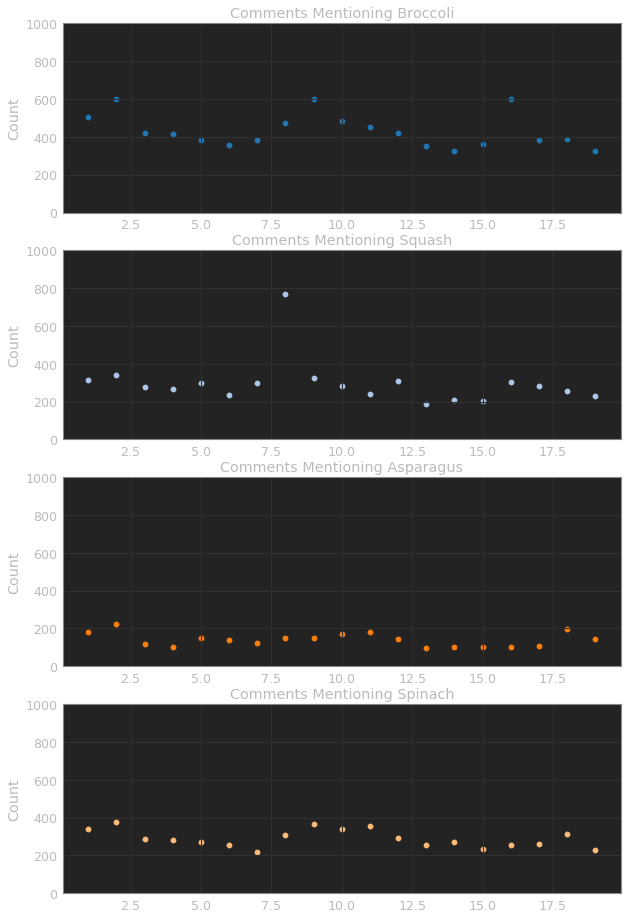

In [8]:

import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(words),1) #(len(words), 1)
fig.set_size_inches(10, 4*4)

ax[0].set_title(f'Comments Mentioning {word.title()}')

for ii, word in enumerate(words):
    times = [x.get('created_utc') for x in data[word]['comment']]
    h,b = np.histogram( 
        times, 
        bins=np.arange( after, before+1, 24*60**2))

    ax[ii].scatter((b[1:] - after)/(24*60**2), h, color=cmap[ii])
    ax[ii].set_title(f'Comments Mentioning {word.title()}')
    ax[ii].set_ylabel('Count')
    ax[ii].set_ylim(0,1000)


Once we have the daily totals computed we store them in the MongoDB

In [10]:
import pymongo

client = pymongo.MongoClient('mongodb://localhost:27017')
db = client.ETL

for word in words:
    for typ in data[word]:
        times = [x.get('created_utc') for x in data[word][typ]]
        hist,bins = np.histogram( 
            times,
            bins=np.arange(min(times)-1, max(times)+1, 24*60**2))
        
        db.mentions.insert_many([
            {'word': word, 'type': typ, 
             'mentions': int(v), 
             'datetime_utc': int(d)} \
             for v,d in zip(hist,bins[1:])])
